# Training the classification model

First, reload in the dataset with as many images as possible

In [1]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch
from utils import *
import matplotlib.pyplot as plt

class PersonDataset(Dataset):

    def __init__(self, annot_path, img_dir, img_dim, categories):
        self.annot_path = annot_path
        self.img_dir =  img_dir
        self.img_dim =  img_dim
        self.categories =  categories

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
    
    def __len__(self):
        return len(self.img_data_all)
    
    def __getitem__(self, index):
        return self.img_data_all[index], self.gt_bboxes_all[index], self.gt_classes_all[index]
    
    def get_data(self):
        max_objects = 10
        
        #get_boxes_all has shape (B, n_images, max_objects, 4) where B is batch size
        df_images = filter_aspect_ratio(self.annot_path, 1.6, 1.4)
        gt_boxes_all, gt_idxs_all, img_data_all = load_dataset(self.annot_path, self.img_dir, max_objects, self.img_dim, df_images)

        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1) #pad if there are images with < max_objects
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)

        img_data_stacked = torch.stack(img_data_all, dim=0)

        print('total length of image data is', len(img_data_stacked))
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad
img_width = 600
img_height = 400
name2idx = {'pad': -1, 'person': 1}
categories = {v:k for k, v in name2idx.items()}

annotation_path = './mmdetection/data/coco/annotations/instances_train2017.json'
image_dir = './mmdetection/data/coco/train2017/'
od_dataset = PersonDataset(annotation_path, image_dir, (img_height, img_width), categories)
od_dataloader = DataLoader(od_dataset, batch_size=2)

100%|██████████| 5422/5422 [10:10<00:00,  8.88it/s]


total length of image data is 1786


load in the model and define a training loop, plot the loss

In [2]:
from model import *
out_c, out_h, out_w = (2048, 13, 19)
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = Detector(img_size, out_size, out_c, n_classes, roi_size)

100%|██████████| 1000/1000 [20:31:04<00:00, 73.86s/it]     


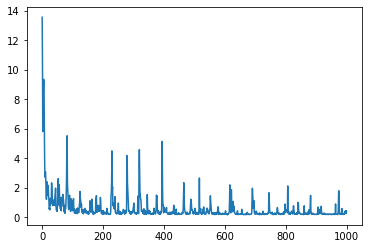

In [ ]:
from tqdm import tqdm


def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

plt.plot(loss_list)
torch.save(detector.state_dict(), "model_6.pt")